# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [4]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [16]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 16.0 Training loss: 1.0198 Explore P: 0.9984
Episode: 2 Total reward: 15.0 Training loss: 1.1059 Explore P: 0.9969
Episode: 3 Total reward: 11.0 Training loss: 0.9824 Explore P: 0.9959
Episode: 4 Total reward: 25.0 Training loss: 1.0245 Explore P: 0.9934
Episode: 5 Total reward: 29.0 Training loss: 0.9319 Explore P: 0.9905
Episode: 6 Total reward: 37.0 Training loss: 1.1257 Explore P: 0.9869
Episode: 7 Total reward: 19.0 Training loss: 1.0890 Explore P: 0.9851
Episode: 8 Total reward: 30.0 Training loss: 0.9572 Explore P: 0.9821
Episode: 9 Total reward: 34.0 Training loss: 1.1916 Explore P: 0.9788
Episode: 10 Total reward: 10.0 Training loss: 1.1645 Explore P: 0.9779
Episode: 11 Total reward: 27.0 Training loss: 1.0530 Explore P: 0.9753
Episode: 12 Total reward: 19.0 Training loss: 1.1576 Explore P: 0.9734
Episode: 13 Total reward: 14.0 Training loss: 1.1145 Explore P: 0.9721
Episode: 14 Total reward: 15.0 Training loss: 1.1526 Explore P: 0.9706
Episode: 15 Tot

Episode: 118 Total reward: 27.0 Training loss: 123.2917 Explore P: 0.7803
Episode: 119 Total reward: 12.0 Training loss: 184.8054 Explore P: 0.7794
Episode: 120 Total reward: 11.0 Training loss: 6.3988 Explore P: 0.7785
Episode: 121 Total reward: 11.0 Training loss: 128.4341 Explore P: 0.7777
Episode: 122 Total reward: 18.0 Training loss: 264.1418 Explore P: 0.7763
Episode: 123 Total reward: 12.0 Training loss: 5.1441 Explore P: 0.7754
Episode: 124 Total reward: 13.0 Training loss: 296.7255 Explore P: 0.7744
Episode: 125 Total reward: 12.0 Training loss: 5.5934 Explore P: 0.7735
Episode: 126 Total reward: 12.0 Training loss: 5.3560 Explore P: 0.7726
Episode: 127 Total reward: 10.0 Training loss: 281.5390 Explore P: 0.7718
Episode: 128 Total reward: 10.0 Training loss: 137.9097 Explore P: 0.7711
Episode: 129 Total reward: 18.0 Training loss: 4.1594 Explore P: 0.7697
Episode: 130 Total reward: 13.0 Training loss: 116.2230 Explore P: 0.7687
Episode: 131 Total reward: 11.0 Training loss: 1

Episode: 234 Total reward: 28.0 Training loss: 66.8689 Explore P: 0.6491
Episode: 235 Total reward: 20.0 Training loss: 4.4259 Explore P: 0.6478
Episode: 236 Total reward: 15.0 Training loss: 3.5549 Explore P: 0.6468
Episode: 237 Total reward: 12.0 Training loss: 4.4384 Explore P: 0.6461
Episode: 238 Total reward: 12.0 Training loss: 66.9455 Explore P: 0.6453
Episode: 239 Total reward: 11.0 Training loss: 117.0496 Explore P: 0.6446
Episode: 240 Total reward: 9.0 Training loss: 153.0529 Explore P: 0.6440
Episode: 241 Total reward: 12.0 Training loss: 76.6754 Explore P: 0.6433
Episode: 242 Total reward: 11.0 Training loss: 106.1667 Explore P: 0.6426
Episode: 243 Total reward: 8.0 Training loss: 3.5323 Explore P: 0.6421
Episode: 244 Total reward: 15.0 Training loss: 35.6410 Explore P: 0.6411
Episode: 245 Total reward: 9.0 Training loss: 3.1268 Explore P: 0.6406
Episode: 246 Total reward: 31.0 Training loss: 142.9915 Explore P: 0.6386
Episode: 247 Total reward: 10.0 Training loss: 3.2966 E

Episode: 347 Total reward: 25.0 Training loss: 53.8808 Explore P: 0.5483
Episode: 348 Total reward: 40.0 Training loss: 19.7258 Explore P: 0.5462
Episode: 349 Total reward: 16.0 Training loss: 23.7622 Explore P: 0.5453
Episode: 350 Total reward: 27.0 Training loss: 44.0774 Explore P: 0.5439
Episode: 351 Total reward: 29.0 Training loss: 1.5885 Explore P: 0.5424
Episode: 352 Total reward: 57.0 Training loss: 59.7472 Explore P: 0.5393
Episode: 353 Total reward: 77.0 Training loss: 1.6966 Explore P: 0.5353
Episode: 354 Total reward: 69.0 Training loss: 22.1316 Explore P: 0.5317
Episode: 355 Total reward: 32.0 Training loss: 17.9631 Explore P: 0.5300
Episode: 356 Total reward: 30.0 Training loss: 1.7201 Explore P: 0.5284
Episode: 357 Total reward: 49.0 Training loss: 1.7749 Explore P: 0.5259
Episode: 358 Total reward: 55.0 Training loss: 2.0882 Explore P: 0.5231
Episode: 359 Total reward: 23.0 Training loss: 0.6970 Explore P: 0.5219
Episode: 360 Total reward: 19.0 Training loss: 17.0347 Ex

Episode: 460 Total reward: 133.0 Training loss: 1.6815 Explore P: 0.2780
Episode: 461 Total reward: 92.0 Training loss: 25.1552 Explore P: 0.2755
Episode: 462 Total reward: 96.0 Training loss: 1.1551 Explore P: 0.2730
Episode: 463 Total reward: 92.0 Training loss: 51.3964 Explore P: 0.2706
Episode: 464 Total reward: 153.0 Training loss: 2.6881 Explore P: 0.2666
Episode: 465 Total reward: 165.0 Training loss: 14.3341 Explore P: 0.2624
Episode: 466 Total reward: 153.0 Training loss: 19.1216 Explore P: 0.2586
Episode: 467 Total reward: 96.0 Training loss: 1.8465 Explore P: 0.2562
Episode: 468 Total reward: 154.0 Training loss: 1.0829 Explore P: 0.2524
Episode: 469 Total reward: 149.0 Training loss: 1.8631 Explore P: 0.2488
Episode: 470 Total reward: 127.0 Training loss: 1.2823 Explore P: 0.2458
Episode: 471 Total reward: 104.0 Training loss: 3.8077 Explore P: 0.2434
Episode: 472 Total reward: 141.0 Training loss: 208.5461 Explore P: 0.2401
Episode: 473 Total reward: 200.0 Training loss: 0

Episode: 613 Total reward: 16.0 Training loss: 2.3200 Explore P: 0.0509
Episode: 614 Total reward: 17.0 Training loss: 4.3892 Explore P: 0.0508
Episode: 615 Total reward: 16.0 Training loss: 3.1371 Explore P: 0.0507
Episode: 616 Total reward: 13.0 Training loss: 2.7722 Explore P: 0.0507
Episode: 617 Total reward: 14.0 Training loss: 5.7089 Explore P: 0.0506
Episode: 618 Total reward: 16.0 Training loss: 5.7043 Explore P: 0.0505
Episode: 619 Total reward: 17.0 Training loss: 7.9855 Explore P: 0.0505
Episode: 620 Total reward: 19.0 Training loss: 4.3425 Explore P: 0.0504
Episode: 621 Total reward: 16.0 Training loss: 2.2172 Explore P: 0.0503
Episode: 622 Total reward: 16.0 Training loss: 5.1029 Explore P: 0.0503
Episode: 623 Total reward: 16.0 Training loss: 1.4885 Explore P: 0.0502
Episode: 624 Total reward: 16.0 Training loss: 3.2103 Explore P: 0.0501
Episode: 625 Total reward: 16.0 Training loss: 7.0983 Explore P: 0.0501
Episode: 626 Total reward: 16.0 Training loss: 3.9823 Explore P:

Episode: 808 Total reward: 99.0 Training loss: 0.6191 Explore P: 0.0144
Episode: 811 Total reward: 99.0 Training loss: 0.9831 Explore P: 0.0142
Episode: 814 Total reward: 49.0 Training loss: 0.3539 Explore P: 0.0140
Episode: 817 Total reward: 8.0 Training loss: 0.5052 Explore P: 0.0139
Episode: 820 Total reward: 99.0 Training loss: 0.3008 Explore P: 0.0137
Episode: 823 Total reward: 99.0 Training loss: 0.2182 Explore P: 0.0135
Episode: 826 Total reward: 99.0 Training loss: 0.2057 Explore P: 0.0133
Episode: 829 Total reward: 99.0 Training loss: 0.1053 Explore P: 0.0132
Episode: 832 Total reward: 99.0 Training loss: 149.2908 Explore P: 0.0130
Episode: 835 Total reward: 99.0 Training loss: 0.1524 Explore P: 0.0129
Episode: 838 Total reward: 99.0 Training loss: 0.8654 Explore P: 0.0127
Episode: 841 Total reward: 52.0 Training loss: 0.2118 Explore P: 0.0126
Episode: 844 Total reward: 99.0 Training loss: 0.1627 Explore P: 0.0125
Episode: 847 Total reward: 99.0 Training loss: 0.1524 Explore P

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

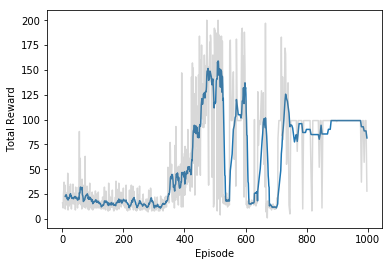

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')